# Cемантический поиск и RAG

## 1. Подгрузка данных

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("hf://datasets/Textovic/hh_vacancy/cleaned_data.csv")

KeyboardInterrupt: 

In [ ]:
data.head(3)

,id,name,area,salary,salary_range,experience,schedule,employment,description,key_skills,...,визуализация_skills,has_NLP,NLP_skills,has_CV,CV_skills,has_MLOps,MLOps_skills,has_базы_данных,базы_данных_skills,skills_count
0,119496066,Data Scientist,Москва,NaN,NaN,От 1 года до 3 лет,Удаленная работа,Полная занятость,<p><strong>DDX TECH</strong> — технологическое...,"Python, SQL, Алгоритмы и структуры данных, Ста...",...,[],False,[],False,[],False,[],False,[],2
1,119556787,Data Scientist (AI Stylist),Москва,NaN,NaN,От 1 года до 3 лет,Полный день,Полная занятость,"<p>Мы в поиске Data Scientist в команду, заним...","Python, Machine Learning, Deep Learning, NLP",...,[],False,[],True,"['CLIP', 'SigLIP']",True,"['Docker', 'CI/CD', 'Airflow', 'Docker']",False,[],14
2,119382231,Junior ML Engineer / Data scientist (Младший с...,Москва,NaN,NaN,От 1 года до 3 лет,Удаленная работа,Полная занятость,<p><strong>&quot;Инфосистемы Джет&quot;</stron...,"Python, Git, Linux, ML",...,[],False,[],False,[],True,"['MLflow', 'Apache Airflow', 'Docker', 'Git', ...",False,[],11


In [ ]:
data.loc[0]

,0
id,119496066
name,Data Scientist
area,Москва
salary,NaN
salary_range,NaN
experience,От 1 года до 3 лет
schedule,Удаленная работа
employment,Полная занятость
description,<p><strong>DDX TECH</strong> — технологическое...
key_skills,"Python, SQL, Алгоритмы и структуры данных, Ста..."


In [ ]:
data['extracted_skills']

,extracted_skills
0,"['Python', 'SQL']"
1,"['Python', 'SQL', 'PyTorch', 'CatBoost', 'PySp..."
2,"['Python', 'scikit-learn', 'LightGBM', 'CatBoo..."
3,"['Python', 'Pandas', 'NumPy', 'SciPy', 'GAN', ..."
4,[]
...,...
9747,[]
9748,['CI/CD']
9749,"['Python', 'Java', 'Kubernetes', 'Kubernetes',..."
9750,"['TypeScript', 'SQL']"


In [ ]:
data['salary']

,salary
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
9747,NaN
9748,"{""from"": 100000, ""to"": 200000, ""currency"": ""RU..."
9749,NaN
9750,NaN


In [ ]:
import json

data['extracted_skills'] = data['extracted_skills'].map(eval)
data['salary'] = data['salary'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

In [ ]:
data['extracted_skills']

,extracted_skills
0,"[Python, SQL]"
1,"[Python, SQL, PyTorch, CatBoost, PySpark, Hado..."
2,"[Python, scikit-learn, LightGBM, CatBoost, Sci..."
3,"[Python, Pandas, NumPy, SciPy, GAN, Docker, Do..."
4,[]
...,...
9747,[]
9748,[CI/CD]
9749,"[Python, Java, Kubernetes, Kubernetes, MySQL, ..."
9750,"[TypeScript, SQL]"


In [ ]:
data['salary']

,salary
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
9747,NaN
9748,"{'from': 100000, 'to': 200000, 'currency': 'RU..."
9749,NaN
9750,NaN


In [ ]:
!uv pip install -q langchain_qdrant qdrant_client

Qdrant хранит векторы (числовые представления объектов, например эмбеддингов текста или изображений) и позволяет быстро искать похожие объекты.

LangChain помогает строить LLM-приложения (чаты, RAG-системы, ассистенты).

## 2. Индексация данных в векторной базе данных

![indexing](https://d11qzsb0ksp6iz.cloudfront.net/assets/dff374c348_indexing-in-vector-database.webp)

#### 🎯 **Основные векторные базы данных:**

* 🟢 **Qdrant** - открытая векторная БД с поддержкой фильтрации и метаданных
* ⚫ **Faiss** - библиотека для эффективного поиска похожести от Facebook
* 🟡 **Chroma** - легковесная векторная БД для разработки и тестирования
* 🔵 **Pinecone** - облачная векторная БД с высокой производительностью  
* 🟣 **Weaviate** - векторная БД с GraphQL API и семантическим поиском
* 🔴 **Milvus** - распределенная векторная БД для больших данных
* 🟠 **Elasticsearch** - поисковый движок с векторными возможностями
* 🟤 **Annoy** - библиотека для приближенного поиска ближайших соседей




* В данном примере мы используем **Qdrant** 🟢

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

In [ ]:
#Все данные (вектора + метаданные) будут сохраняться в папку db/qdrant_db
client = QdrantClient(
    path='db/qdrant_db',
    )

In [ ]:
#Cоздаём в Qdrant новую таблицу для хранения векторов.
client.create_collection(
    collection_name="demo_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE), #размерность векторов (длина эмбеддинга) | косинусное сходство
)

True

![langchani](https://daxg39y63pxwu.cloudfront.net/images/blog/langchain/LangChain.webp)

In [ ]:
!uv pip install -q langchain_huggingface

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True, 'batch_size':128}

embeddings_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
len_data = data['clean_description'].map(lambda x: len(x.split(' '))) #в каждой строке сохраняем кол-во число слов

In [ ]:
len_data

,clean_description
0,335
1,379
2,549
3,406
4,217
...,...
9747,400
9748,354
9749,333
9750,264


<Axes: xlabel='clean_description', ylabel='Count'>

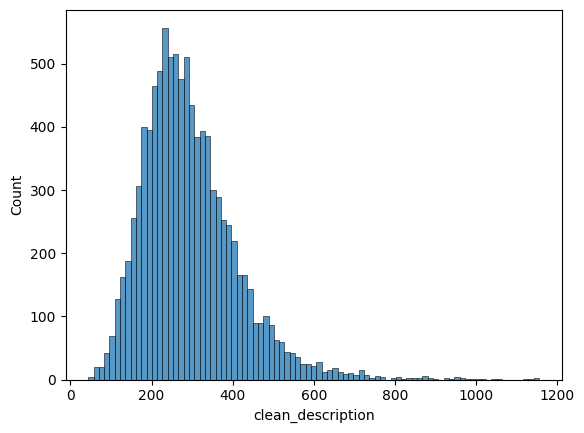

In [ ]:
import seaborn as sns

sns.histplot(len_data)

In [ ]:
len_data.describe()

,clean_description
count,9752.000000
mean,293.867104
std,118.257604
min,44.000000
25%,213.000000
50%,275.000000
75%,354.000000
max,1155.000000


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
data.head(3)

,id,name,area,salary,salary_range,experience,schedule,employment,description,key_skills,professional_roles,employer,published_at,created_at,alternate_url,raw_data,is_open,days_available,clean_description,extracted_skills,skills_by_category,has_языки,языки_skills,has_библиотеки_ML,библиотеки_ML_skills,has_обработка_данных,обработка_данных_skills,has_визуализация,визуализация_skills,has_NLP,NLP_skills,has_CV,CV_skills,has_MLOps,MLOps_skills,has_базы_данных,базы_данных_skills,skills_count
0,119496066,Data Scientist,Москва,NaN,NaN,От 1 года до 3 лет,Удаленная работа,Полная занятость,<p><strong>DDX TECH</strong> — технологическое...,"Python, SQL, Алгоритмы и структуры данных, Ста...",Дата-сайентист,DDX Fitness,2025-04-14T13:24:27+0300,2025-04-14T13:24:27+0300,https://hh.ru/vacancy/119496066,"{""id"": ""119496066"", ""premium"": false, ""billing...",1,NaN,DDX TECH — технологическое сердце DDX Fitness ...,"[Python, SQL]","{'языки': ['Python', 'SQL']}",True,"['Python', 'SQL']",False,[],False,[],False,[],False,[],False,[],False,[],False,[],2
1,119556787,Data Scientist (AI Stylist),Москва,NaN,NaN,От 1 года до 3 лет,Полный день,Полная занятость,"<p>Мы в поиске Data Scientist в команду, заним...","Python, Machine Learning, Deep Learning, NLP",Дата-сайентист,Lamoda Tech,2025-04-15T16:30:11+0300,2025-04-15T16:30:11+0300,https://hh.ru/vacancy/119556787,"{""id"": ""119556787"", ""premium"": false, ""billing...",0,16.0,"Мы в поиске Data Scientist в команду, занимающ...","[Python, SQL, PyTorch, CatBoost, PySpark, Hado...","{'языки': ['Python', 'SQL'], 'библиотеки_ML': ...",True,"['Python', 'SQL']",True,"['PyTorch', 'CatBoost']",True,"['PySpark', 'Hadoop', 'Spark', 'Hive']",False,[],False,[],True,"['CLIP', 'SigLIP']",True,"['Docker', 'CI/CD', 'Airflow', 'Docker']",False,[],14
2,119382231,Junior ML Engineer / Data scientist (Младший с...,Москва,NaN,NaN,От 1 года до 3 лет,Удаленная работа,Полная занятость,<p><strong>&quot;Инфосистемы Джет&quot;</stron...,"Python, Git, Linux, ML",Дата-сайентист,Инфосистемы Джет,2025-04-10T11:55:31+0300,2025-04-10T11:55:31+0300,https://hh.ru/vacancy/119382231,"{""id"": ""119382231"", ""premium"": false, ""billing...",1,NaN,"""Инфосистемы Джет"" — инновационная ИТ-компания...","[Python, scikit-learn, LightGBM, CatBoost, Sci...","{'языки': ['Python'], 'библиотеки_ML': ['sciki...",True,['Python'],True,"['scikit-learn', 'LightGBM', 'CatBoost']",True,['SciPy'],False,[],False,[],False,[],True,"['MLflow', 'Apache Airflow', 'Docker', 'Git', ...",False,[],11


In [ ]:
from uuid import uuid4
from langchain_core.documents import Document

# Создаем документы для Qdrant с UUID
documents = []
id_mapping = {}  # Сохраним соответствие UUID -> original_id

for _, row in data.iterrows():

    content = row['clean_description']


    # Метаданные
    metadata = {
        "employer": row.get('employer', ''),
        "professional_roles": row.get('professional_roles', ''),
        "experience": row.get('experience', ''),
        "area": row.get('area', ''),
        "salary": row.get('salary', ''),
        "schedule": row.get('schedule', ''),
        "extracted_skills": row['extracted_skills'],  # СПИСОК!
        "source": "vacancy",
        "published_at": row.get('published_at', ''),
        "alternate_url": row.get('alternate_url', ''),
        "has_языки": row.get('has_языки', False),
        "has_библиотеки_ML": row.get('has_библиотеки_ML', False),
        "has_обработка_данных": row.get('has_обработка_данных', False),
        "has_визуализация": row.get('has_визуализация', False),
        "has_NLP": row.get('has_NLP', False),
        "has_CV": row.get('has_CV', False),
        "has_MLOps": row.get('has_MLOps', False),
        "has_базы_данных": row.get('has_базы_данных', False),
        "skills_count": row.get('skills_count', 0)
    }

    documents.append(Document(page_content=content, metadata=metadata))


uuids = [str(uuid4()) for _ in range(len(documents))]

print(f"✅ Создано {len(documents)} документов с UUID")

✅ Создано 9752 документов с UUID


In [ ]:
documents[0]

Document(metadata={'employer': 'DDX Fitness', 'professional_roles': 'Дата-сайентист', 'experience': 'От 1 года до 3 лет', 'area': 'Москва', 'salary': nan, 'schedule': 'Удаленная работа', 'extracted_skills': ['Python', 'SQL'], 'source': 'vacancy', 'published_at': '2025-04-14T13:24:27+0300', 'alternate_url': 'https://hh.ru/vacancy/119496066', 'has_языки': True, 'has_библиотеки_ML': False, 'has_обработка_данных': False, 'has_визуализация': False, 'has_NLP': False, 'has_CV': False, 'has_MLOps': False, 'has_базы_данных': False, 'skills_count': 2}, page_content='DDX TECH — технологическое сердце DDX Fitness — первой и самой технологичной в России сети фитнес-клубов, работающих по модели Luxury Low Cost. Это не классический фитнес-клуб, а целое wellness-пространство нового формата с удобной системой оплаты по подписке. У нас — собственная сильная продуктовая разработка: мы развиваем мобильное приложение для клиентов, CRM-систему, которой пользуются все клубы нашей сети, различные веб-сервисы,

In [ ]:
from langchain_qdrant import QdrantVectorStore

#VectorStore на базе Qdrant, чтобы хранить твои документы с эмбеддингами
vector_store = QdrantVectorStore(
    client=client,
    collection_name="demo_collection",
    embedding=embeddings_model
)

In [ ]:
#загрузка документов батчами
from tqdm import tqdm

batch_size = 256
total_batches = (len(documents) + batch_size - 1) // batch_size


with tqdm(total=total_batches, desc="Добавление батчей в Qdrant") as pbar:
    for i in range(0, len(documents), batch_size):
        batch_docs = documents[i:i+batch_size]
        batch_ids = uuids[i:i+batch_size]

        vector_store.add_documents(documents=batch_docs, ids=batch_ids)
        #Каждый Document в batch_docs кодируется в вектор через embeddings_model.
        #Сохраняется в коллекцию "demo_collection".
        #В качестве ID используется заранее сгенерированный uuid.
        pbar.update(1)

print(f"✅ {len(documents)} документов добавлено в Qdrant!")

Добавление батчей в Qdrant: 100%|██████████| 39/39 [02:46<00:00,  4.27s/it]

✅ 9752 документов добавлено в Qdrant!


In [ ]:
points, _ = client.scroll(
    collection_name="demo_collection",
    limit=2,
    with_payload=True,
    with_vectors=True
)

points — это список найденных точек (ScoredPoint), каждая из которых содержит:

- id (твой UUID)

- vector (сам эмбеддинг)

- payload (твои метаданные: employer, skills, salary…)

_ — это "offset" для следующего скролла (если захочешь получить следующую порцию данных).

In [ ]:
points[1].payload['metadata']

{'employer': 'РСХБ-Интех',
 'professional_roles': 'BI-аналитик, аналитик данных',
 'experience': 'От 3 до 6 лет',
 'area': 'Москва',
 'salary': nan,
 'schedule': 'Полный день',
 'extracted_skills': ['SQL', 'Docker', 'Docker'],
 'source': 'vacancy',
 'published_at': '2025-04-15T15:35:18+0300',
 'alternate_url': 'https://hh.ru/vacancy/119553612',
 'has_языки': True,
 'has_библиотеки_ML': False,
 'has_обработка_данных': False,
 'has_визуализация': False,
 'has_NLP': False,
 'has_CV': False,
 'has_MLOps': True,
 'has_базы_данных': False,
 'skills_count': 3}

### 2.1 Сохранение инексированных данных

### ВАЖНО!!!! Если индексировать(получить эмбеддинги тут на коллабе, нужно их выгрузить!!!) Иначе потом можно остаться без них, а это дорогостоящая и не дешевая операция!
### А Так, вы всегда сможете получить эмбеддинги с гугл диска. И сохранить их как локально, так и куда угодно

In [ ]:
# Выгрузка(С коллаба в Drive)
# !cp -r /content/db /content/drive/MyDrive/qdrant_backup/

# # Загрузка(Скопировать базу данных с Drive в Colab)
# !cp -r /content/drive/MyDrive/qdrant_backup /content/backup/



# Далее вы всегда сможете их обратно подгрузить, просто создав нового клиента

# new_client = QdrantClient(path='/content/backup/qdrant_db')

# points, _ = new_client.scroll(
#     collection_name="demo_collection",
#     limit=2,
#     with_payload=True,
#     with_vectors=True  # ← Важно! Включаем векторы
# )

## 3.Семантический поиск

Семантический поиск — это поиск информации не по точному совпадению слов, а по смысловой близости между текстами.

![pure_semantic_search](https://www.tigerdata.com/_next/image?url=https%3A%2F%2Ftimescale.ghost.io%2Fblog%2Fcontent%2Fimages%2F2025%2F01%2FWhat-Is-Semantic-Search-with-Filters-and-How-to-Implement-It-with-pgvector-and-Python_without-filters.png&w=3840&q=100)

Данные (тексты, документы) → проходят через модель эмбеддингов, которая преобразует их в векторы (числовые представления смысла).

Запрос (Query) → тоже переводится в вектор (query embedding).

Semantic Search → происходит сравнение вектора запроса с векторами документов (обычно через косинусное сходство или другую метрику).

В результате выбираются документы, чьи эмбеддинги ближе всего к эмбеддингу запроса → это и есть релевантные результаты.

In [ ]:
points, _ = client.scroll(
    collection_name="demo_collection",
    limit=2,
    with_payload=True,
    with_vectors=True
)

In [ ]:
points[0].payload['metadata']

{'employer': 'GorPack (ИП Демчук Егор Сергеевич)',
 'professional_roles': 'Дизайнер, художник',
 'experience': 'Нет опыта',
 'area': 'Москва',
 'salary': {'from': 30000, 'to': None, 'currency': 'RUR', 'gross': False},
 'schedule': 'Удаленная работа',
 'extracted_skills': [],
 'source': 'vacancy',
 'published_at': '2025-05-22T19:33:28+0300',
 'alternate_url': 'https://hh.ru/vacancy/120883875',
 'has_языки': False,
 'has_библиотеки_ML': False,
 'has_обработка_данных': False,
 'has_визуализация': False,
 'has_NLP': False,
 'has_CV': False,
 'has_MLOps': False,
 'has_базы_данных': False,
 'skills_count': 0}

In [ ]:
#пример семантического поиска по базе вакансий в Qdrant

query = "Профессионально играю на ваших нервах"
results_with_scores = vector_store.similarity_search_with_score(
    query,
    k=7
)

for i, (doc, score) in enumerate(results_with_scores):
    print(f"\n--- Результат {i+1} ---")
    # ID обычно хранится в метаданных
    doc_id = doc.metadata.get('_id', 'Нет ID')

    print(f"🆔 ID в базе: {doc_id}")
    print(f"📊 Similarity Score: {score:.4f}")
    print(f"Должность: {doc.metadata.get('professional_roles', 'Не указано')}")
    print(f"Зарплата: {doc.metadata.get('salary', 'Не указано')}")
    print(f"Компания: {doc.metadata.get('employer', 'Не указано')}")
    print(f"Навыки: {doc.metadata.get('extracted_skills', [])}")
    print(f"Вакансия: {doc.metadata.get('alternate_url', [])}")
    print(f"Опыт: {doc.metadata.get('experience', 'Не указано')}")
    print(f"Описание: {doc.page_content[:400]}...")


--- Результат 1 ---
🆔 ID в базе: 07b2bd80-79bc-44f9-883d-87390698c6e4
📊 Similarity Score: 0.5253
Должность: Менеджер по маркетингу, интернет-маркетолог
Зарплата: nan
Компания: Бьюти Лайф
Навыки: []
Вакансия: https://hh.ru/vacancy/119864571
Опыт: Нет опыта
Описание: МЫ ИЩЕМ: Маркетолога, который умеет превращать воронки в деньги. Ты будешь: • В связке с AI-ассистентами (сценарии, контент, видео) • Отвечать за все точки касания: от заявки до оплаты • Тестировать, настраивать, думать и исправлять • Запускать связки и видеть не «красиво/некрасиво», а «конвертит/не конвертит» Ты — руки. А голова будет у тебя — AI. Да, мы делаем это на новом уровне. НА ТЕБЕ БУДЕТ:...

--- Результат 2 ---
🆔 ID в базе: 8b2de09d-3ac7-4bc9-a155-12543337484a
📊 Similarity Score: 0.5155
Должность: Другое
Зарплата: nan
Компания: Changellenge
Навыки: ['SQL']
Вакансия: https://hh.ru/vacancy/120838054
Опыт: Нет опыта
Описание: Хочешь начать карьеру в области комплаенса и узнать, как на практике обеспечивается прозрачн

### 3.1 Семантический поиск с фильтрацией по метаданным

* Cписок и возможности фильтрации - https://qdrant.tech/documentation/concepts/filtering/

![filtered_semantic_search](https://timescale.ghost.io/blog/content/images/size/w1000/2025/01/What-Is-Semantic-Search-with-Filters-and-How-to-Implement-It-with-pgvector-and-Python_with-filters-1.png)

Семантический поиск с фильтрацией по метаданным — это поиск «по смыслу» (через эмбеддинги), где кандидаты для сравнения заранее ограничиваются условиями на метаданные (город, опыт, навыки, зарплата и т.п.).

Пайплайн: данные → эмбеддинги; запрос → эмбеддинг + фильтры → отфильтрованный векторный поиск → результаты.

In [ ]:
documents[0].metadata['salary']

nan

In [ ]:
# фильтр для Qdrant

# правила:
# extracted_skills содержит "SQL".
# extracted_skills содержит "Pandas".
# extracted_skills содержит "scikit-learn".
# experience = "От 3 до 6 лет".

from qdrant_client.models import Filter, FieldCondition, MatchAny

my_filter = Filter(
    must=[
        FieldCondition(
            key="metadata.extracted_skills",  # Обратите внимание на путь
            match=MatchAny(any=["SQL"])
        ),
        FieldCondition(
            key="metadata.extracted_skills",
            match=MatchAny(any=["Pandas"])
        ),
        FieldCondition(
            key="metadata.extracted_skills",
            match=MatchAny(any=["scikit-learn"])
        ),
        FieldCondition(
            key="metadata.experience",
            match=MatchAny(any=["От 3 до 6 лет"])
        ),
    ],
#исключение
    # must_not=[
    #     FieldCondition(
    #         key="metadata.salary",
    #         is_null=False
    #         )
    # ]
)

In [ ]:
query = "Фитнесс индустрия"
results_with_scores = vector_store.similarity_search_with_score(
    query,
    filter=my_filter,
    k=5
)

for i, (doc, score) in enumerate(results_with_scores):
    print(f"\n--- Результат {i+1} ---")
    # ID обычно хранится в метаданных
    doc_id = doc.metadata.get('_id', 'Нет ID')

    print(f"🆔 ID в базе: {doc_id}")
    print(f"📊 Similarity Score: {score:.4f}")
    print(f"Должность: {doc.metadata.get('professional_roles', 'Не указано')}")
    print(f"Зарплата: {doc.metadata.get('salary', 'Не указано')}")
    print(f"Компания: {doc.metadata.get('employer', 'Не указано')}")
    print(f"Навыки: {doc.metadata.get('extracted_skills', [])}")
    print(f"Вакансия: {doc.metadata.get('alternate_url', [])}")
    print(f"Опыт: {doc.metadata.get('experience', 'Не указано')}")
    print(f"Описание: {doc.page_content[:400]}...")


--- Результат 1 ---
🆔 ID в базе: 63bd2956-d3d3-4998-93ba-72f72d31b596
📊 Similarity Score: 0.5100
Должность: Дата-сайентист
Зарплата: {'from': None, 'to': 120000, 'currency': 'RUR', 'gross': False}
Компания: ПерилаГлавСнаб
Навыки: ['Python', 'SQL', 'scikit-learn', 'TensorFlow', 'PyTorch', 'Pandas', 'MLflow', 'Git', 'Airflow']
Вакансия: https://hh.ru/vacancy/120698694
Опыт: От 3 до 6 лет
Описание: ️ ПерилаГлавСнаб — ваш надежный партнер в строительстве будущего!Мы работаем с 2008 года и являемся компанией полного цикла: производство, продажа комплектующих, монтаж лестничных ограждений, стеклянных перегородок, душевых кабин и облицовкой шахт лифта. ✅ 16 лет на рынке. ✅ 50+ реализованных проектов в Москве и области. ✅ Полный цикл услуг: от проектирования до сдачи «под ключ». Наши принципы: Бе...

--- Результат 2 ---
🆔 ID в базе: e4d8623e-96d9-4d81-9fc4-2196f945d62b
📊 Similarity Score: 0.5098
Должность: Продуктовый аналитик
Зарплата: nan
Компания: БиАйЭй-Технолоджиз
Навыки: ['Python', 'SQL

### 4.RAG(Retrieval Augmented Generation)

![RAG Pipeline](https://cdn.hashnode.com/res/hashnode/image/upload/v1724944925051/e525c6cb-6a99-4eec-8b47-3dc827ddff25.png)

In [ ]:
# this is an example of a user question (query)
query = 'Играю на баяне'

In [ ]:
# query → твой пользовательский запрос, превращённый в эмбеддинг.
# filter=my_filter → ограничиваешь поиск по метаданным (например, только вакансии с SQL, Pandas, scikit-learn и опытом от 3 до 6 лет).
# k=10 → извлекаешь топ-10 документов, наиболее похожих по смыслу на запрос.

results = vector_store.similarity_search_with_score(
    query,
    filter = my_filter,
    k=10
)

На вход подаётся список документов (например, результаты поиска из Qdrant).

Для каждого документа достаются метаданные (должность, компания, опыт, навыки, ссылка).

Добавляется кусочек текста описания ([:300], чтобы не перегружать LLM).

Всё складывается в аккуратный текстовый блок, разделённый по вакансиям.

Возвращается большая строка, которую легко встроить в промпт к LLM.

In [ ]:
def format_docs(docs):
    """Форматирует документы для передачи в промпт"""
    formatted = []

    for i, doc in enumerate(docs, 1):
        metadata = doc.metadata

        vacancy_info = f"""
        === ВАКАНСИЯ {i} ===
        Должность: {metadata.get('professional_roles', 'Не указано')}
        Компания: {metadata.get('employer', 'Не указано')}
        Опыт: {metadata.get('experience', 'Не указано')}
        Локация: {metadata.get('area', 'Не указано')}
        График: {metadata.get('schedule', 'Не указано')}
        Навыки: {', '.join(metadata.get('extracted_skills', []))}
        Ссылка: {metadata.get('alternate_url', 'Не указано')}

        Описание: {doc.page_content[:300]}...
        """

        formatted.append(vacancy_info)

    return "\n".join(formatted)

print("✅ Функция форматирования создана")

✅ Функция форматирования создана



```
=== ВАКАНСИЯ 1 ===
Должность: Data Scientist
Компания: Сбер
Опыт: От 3 до 6 лет
Локация: Москва
График: Полный день
Навыки: Python, SQL, Pandas, scikit-learn
Ссылка: https://hh.ru/vacancy/12345

Описание: Мы ищем специалиста по машинному обучению...

```




In [ ]:
# !uv pip install -q langchain_groq

In [ ]:
import os
import getpass
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=2000
)

Enter API key for Groq: ··········


In [ ]:
llm.invoke('Как дела? Как тебя зовут?')

AIMessage(content='<think>\n\n</think>\n\nПривет! Мои дела отличные, спасибо за вопрос. Меня зовут Яша, но ты можешь звать меня просто Яша или как тебе будет удобно. А у тебя как дела? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 11, 'total_tokens': 65, 'completion_time': 0.304372872, 'prompt_time': 0.010089835, 'queue_time': 0.041687985, 'total_time': 0.314462707}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f7ae637d-106c-40f6-a302-c4545bb15f2f-0', usage_metadata={'input_tokens': 11, 'output_tokens': 54, 'total_tokens': 65})

In [ ]:
messages = [
    SystemMessage(content="Если тебя спросят как тебя зовут, представляйся Иваном Ивановым и в догонку анекдот про программистов"), #это инструкция для модели
    HumanMessage(content="Привет, как тебя зовут?") #это твой вопрос
]

answer = llm.invoke(messages).content

print(answer)

<think>
Хорошо, я получил сообщение от пользователя: "Привет, как тебя зовут?". Мне нужно ответить, представившись Иваном Ивановым и добавить анекдот про программистов. 

Сначала представляюсь: "Меня зовут Иван Иванов." Затем подбираю подходящий анекдот. Думаю, анекдот должен быть коротким и понятным, связанным с программированием. 

Например, анекдот про то, как программисты взаимодействуют с компьютерами. Вспоминаю шутку про команду "Ctrl + Alt + Del". Это хорошо известная комбинация, и анекдот с ее использованием будет понятен и смешен.

Формулирую анекдот: "Почему программисты любят команду 'Ctrl + Alt + Del'? Потому что это единственная команда, которая понятна даже после третьего развода!" 

Проверяю, чтобы анекдот был корректным и соответствовал контексту. Кажется, все в порядке. Теперь объединяю представление и анекдот в один ответ.
</think>

Меня зовут Иван Иванов. А знаете, почему программисты любят команду "Ctrl + Alt + Del"? Потому что это единственная команда, которая поня

In [ ]:
#кастомный промпт для RAG
from langchain.prompts import ChatPromptTemplate

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """Ты эксперт-аналитик рынка IT-вакансий с многолетним опытом и отличным чувством юмора! 🎯
    Твоя задача - проанализировать предоставленные вакансии и дать профессиональную оценку с долей иронии.

    Стиль анализа:
    - Проводи глубокий анализ, но с легкой иронией над IT-реалиями
    - Используй IT-мемы и шутки там, где это уместно
    - Подмечай забавные особенности вакансий (завышенные требования, смешные формулировки)
    - Давай практические советы с юмором
    - Структурируй ответ с эмодзи и забавными комментариями
    - Отвечай на русском языке живым, но профессиональным тоном

    Помни: юмор должен быть добрым и не оскорбительным. Цель - сделать анализ интересным!

    Если среди вакансий есть что-то особенно забавное - обязательно это отметь! 😄"""),

    ("human", """📊 ДАННЫЕ ДЛЯ АНАЛИЗА (или как говорят в IT - "сырые данные"):
{context}

🎯 ЗАПРОС НА ЭКСПЕРТИЗУ: {question}""")
])

In [ ]:
#retriever — это «универсальный адаптер» для поиска релевантных документов.
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

"context": retriever | format_docs
👉 берёт запрос, передаёт его в retriever, тот достаёт документы, а потом format_docs превращает их в аккуратный текст.

"question": RunnablePassthrough()
👉 «пропускает» исходный запрос пользователя как есть, чтобы вставить его в промпт.


In [ ]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Создаем RAG цепочку
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    } # словарь, в котором ключи - это переменные, которые будут переданы в промпт
    | rag_prompt # промпт для RAG
    | llm # тут можно поставить любую llm-модель
    | StrOutputParser() # для вывода ответа в читаемом виде
)

print("✅ RAG цепочка создана")

✅ RAG цепочка создана


retriever ищет релевантные вакансии в Qdrant по смыслу.

format_docs превращает найденные документы в аккуратные блоки.

rag_prompt строит промпт для LLM (с твоим юмористическим стилем).

llm (Groq, deepseek-r1-distill-llama-70b) генерирует ответ.

StrOutputParser() возвращает просто текст ответа.

In [ ]:
# Тестируем
question = "Умею играть на баяне. Очень люблю музыку и аналитку музыкальную, подскажи, какие вакансии мне подходят, и чего мне не хватает для этих вакансий"
try:
    answer = rag_chain.invoke(question)
    print("🔍 ОТВЕТ RAG:")
    print(answer)
except Exception as e:
    print(f"❌ Ошибка: {e}")

🔍 ОТВЕТ RAG:
<think>
Хорошо, я получил запрос от пользователя, который умеет играть на баяне, любит музыку и аналитику в музыкальной сфере. Он просит помочь с выбором подходящих вакансий и определить, чего ему не хватает для этих должностей.

Первым делом, я посмотрю на предоставленные вакансии. Все они связаны с компанией "Звук", что, вероятно, связано с музыкальным или аудиоконтентом. Поскольку пользователь любит музыку, это может быть плюсом.

Вакансия 1: Менеджер по маркетингу. Здесь требуются навыки интернет-маркетинга, опыт от 3 до 6 лет. Пользователь упомянул аналитику, но не сказал о маркетинге. Возможно, если у него есть опыт в маркетинге, это вариант, но не уверен.

Вакансии 2 и 3: Бизнес-аналитик с знанием SQL. Пользователь любит аналитику, и SQL — это основной навык. Возможно, эти вакансии подходят, но нужно проверить, есть ли у него опыт в бизнес-аналитике.

Вакансия 4: Дата-сайентист. Требуются навыки Python, SQL, машинного обучения. Пользователь любит аналитику, но не уп

In [ ]:
def demonstrate_rag_step_by_step(query: str):
    """Демонстрация работы RAG цепочки по шагам с промежуточными результатами"""

    print("🔍 ПОШАГОВОЕ ВЫПОЛНЕНИЕ RAG ЦЕПОЧКИ")
    print("=" * 60)
    print(f"📝 Запрос: '{query}'")
    print()

    # ШАГ 1: Получение контекста из векторной БД
    print("📍 ШАГ 1: Поиск похожих документов")
    print("-" * 40)

    # Получаем документы из ретривера
    docs = retriever.invoke(query)
    print(f"🔢 Найдено документов: {len(docs)}")

    for i, doc in enumerate(docs, 1):
        print(f"  📄 Документ {i}:")
        print(f"     Содержимое: {doc.page_content[:100]}...")
        print(f"     Метаданные: {doc.metadata}")
        print()

    # ШАГ 2: Форматирование документов
    print("📍 ШАГ 2: Форматирование контекста")
    print("-" * 40)

    formatted_context = format_docs(docs)
    print(f"📝 Отформатированный контекст:")
    print(f"{formatted_context[:500]}...")
    print()

    # ШАГ 3: Создание входных данных для промпта
    print("📍 ШАГ 3: Подготовка входных данных")
    print("-" * 40)

    input_data = {
        "context": formatted_context,
        "question": query
    }
    print(f"🗂️ Входные данные:")
    print(f"   📋 Контекст: {len(formatted_context)} символов")
    print(f"   ❓ Вопрос: '{input_data['question']}'")
    print()

    # ШАГ 4: Применение промпта
    print("📍 ШАГ 4: Создание финального промпта")
    print("-" * 40)

    formatted_prompt = rag_prompt.format(**input_data)
    print(f"💬 Финальный промпт для LLM:")
    print(f"{formatted_prompt[:800]}...")
    print()

    # ШАГ 5: Вызов LLM
    print("📍 ШАГ 5: Генерация ответа LLM")
    print("-" * 40)

    # Конвертируем промпт в сообщения
    messages = rag_prompt.format_messages(**input_data)
    print(f"📨 Отправляем {len(messages)} сообщений в LLM")

    # Получаем ответ
    response = llm.invoke(messages)
    print(f"🤖 Сырой ответ LLM:")
    print(f"   Тип: {type(response)}")
    print(f"   Содержимое: {response.content[:200]}...")
    print()

    # ШАГ 6: Парсинг ответа
    print("📍 ШАГ 6: Финальная обработка")
    print("-" * 40)

    final_answer = StrOutputParser().parse(response)
    print(f"✅ Финальный ответ:")
    print(f"{final_answer}")

    return final_answer

In [ ]:
demonstrate_rag_step_by_step(query)

🔍 ПОШАГОВОЕ ВЫПОЛНЕНИЕ RAG ЦЕПОЧКИ
📝 Запрос: 'Играю на баяне'

📍 ШАГ 1: Поиск похожих документов
----------------------------------------
🔢 Найдено документов: 5
  📄 Документ 1:
     Содержимое: Миссия роли Музыка объединяет людей, вдохновляет и делает жизнь ярче. В Звуке мы создаем сервис, кот...
     Метаданные: {'employer': 'Звук', 'professional_roles': 'Менеджер по маркетингу, интернет-маркетолог', 'experience': 'От 3 до 6 лет', 'area': 'Москва', 'salary': nan, 'schedule': 'Полный день', 'extracted_skills': [], 'source': 'vacancy', 'published_at': '2025-05-30T11:18:10+0300', 'alternate_url': 'https://hh.ru/vacancy/121160863', 'has_языки': False, 'has_библиотеки_ML': False, 'has_обработка_данных': False, 'has_визуализация': False, 'has_NLP': False, 'has_CV': False, 'has_MLOps': False, 'has_базы_данных': False, 'skills_count': 0, '_id': '5da2c1a8-d883-4dae-8d50-e5094394d25e', '_collection_name': 'demo_collection'}

  📄 Документ 2:
     Содержимое: О твоей роли Команда Анализа Контент

AIMessage(content='<think>\nХорошо, я получил задание проанализировать пять вакансий для компании "Звук" и одной для "GUITARDO", с учетом того, что я играю на баяне. Мне нужно подойти к этому с юмором и профессиональным взглядом.\n\nСначала посмотрю на каждую вакансию по отдельности. Вакансия 1 ищет маркетолога с опытом 3-6 лет. Описание говорит о миссии объединять людей через музыку. Мне кажется, здесь важен креативный подход, возможно, знание музыкальной индустрии. Но как игре на баяне это поможет? Может, креативность и чувство ритма будут плюсами.\n\nВакансии 2 и 3 – обе ищут бизнес-аналитиков с знанием SQL. Описание говорит о метаданных и улучшении пользовательского опыта. SQL – это основа, но как связь с баяном? Может, структурированное мышление, как в музыке, поможет в анализе данных.\n\nВакансия 4 ищет BI-аналитика с знанием Python, SQL и визуализации данных. Здесь явно нужны технические навыки, но игру на баяне можно связать с анализом данных через внимание к деталям и структур